## Multi-phase-field model for grain growth (Steinbach's model)
This python code was developed by Yamanaka research group of Tokyo University of Agriculture and Technology in August 2019.

## Problem
Let us consider an example: polycrystalline grain growth in a system containing six crystal grains (give crystal grains in a mother phase (grain)). 
This notebook shows two-dimensional multi-phase-field simulation of polycrystalline growth using the multi-phase-field model proposed by Professor Ingo Steinbach. 

For details of the model, please see reference (*I. Steinbach and F. Pezzolla, "A generalized field method for multiphase transformations using interface fields," Physica D: Nonlinear Phenomena, Vol. 134 (1999), pp. 385-393.*).
## Formulation
### 1. Order parameter
Phase-field variable $\phi_{i}$ ($i$ = 1, 2, ..., $N$) is defined as $\phi _{i}= 1$ inside $i$-th grain and $\phi_{i} = 0$ outside of the grain. The phase-field variable $\phi_{i}$ smoothly changes from 0 to 1 in an "diffuse" interfacial region (grain boundary). $N$ is the total number of crystal grains at the initial condition. In this source code, we use $N$ = 6. 

The phase-field variable must satisfies the following constraint: 
$$
\sum_{i=1}^{N}\phi_{i} = 1
$$
### 2. Total free energy
The total Gibbs free energy of the system is defined by
$$
G = \int_{V} \left[ g_{chem} + g_{doub} + g_{grad} + \lambda \left( \sum_{i}^{N}\phi_{i} -1 \right) \right] dV
$$
where $\lambda$ is the Lagrange multiplier in the last term which is introduced into the total free energy so that the sum of the phase-field variable is 1. $g_{chem}$, $g_{doub}$, and $g_{grad}$ are the chemical free energy, the double-obstacle potential energy and the gradient energy densities, respectively. Note that the double-well potential energy is not used, but the double-obstacle potential is used for this multi-phase-field model. These energy densities are defined as follows: 
$$
g_{chem} = \sum_{i}^{N} \phi_{i} g_{i}
$$
$$
g_{doub} = \sum_{i}^{N}\sum_{j=i+1}^{N} W_{ij}\phi_{i}\phi_{j}
$$
$$
g_{grad} = \sum_{i}^{N}\sum_{j=i+1}^{N} \left( -\frac{a_{ij}^{2}}{2}\nabla\phi_{i}\cdot\nabla\phi_{j} \right)
$$
where $g_{i}$ is Gibbs free energy density of $i$-th grain. Here, $g_{i}$ is assumed to be constant. 

$W_{ij}$ and $a_{ij}$ are the height of double-obstacle potential energy and the gradient energy coefficient, respectively, which are given by
$$
W_{ij} = \frac{4\sigma_{ij}}{\delta}
$$
$$
a_{ij} = \frac{2}{\pi}\sqrt{2\delta\sigma_{ij}}
$$
where $\sigma_{ij}$ is the grain boundary energy between $i$-th and $j$-th grains. $\delta$ is the thickness of grain boundary 
(please see Appendix in the handout for the derivations). Note that in this source code, the diagonal components of $\sigma_{ij}$ is assumed  to be zero.  

### 3. Time evolution equation 
The time evolution of the phase-field variables (that describes the grain boundary migration) is given by assuming that the total free energy of the system $G$ decreases monotonically with time. 
$$
\frac{\partial \phi_{i}}{\partial t} = -\frac{2}{N} \sum_{j=1}^{N} M^{\phi}_{ij} \left( \frac{\delta G}{\delta \phi_{i}} - \frac{\delta G}{\delta \phi_{j}} \right)
$$
where the functional derivative is expressed by: 
$$
\frac{\delta G}{\delta \phi}=\frac{\partial g}{\partial \phi}-\nabla\cdot\frac{\partial g}{\partial (\nabla \phi)}
$$
Therefore, 
$$
\frac{\delta G}{\delta \phi_{i}} = \sum_{j=1}^{N} \left( \frac{1}{2} a_{ij}^{2} \nabla^{2}\phi_{j}\right) + \sum_{j=1}^{N} W_{ij}\phi_{j} +g_{i} + \lambda
$$
$M_{ij}^{\phi}$ is the mobility of phase-field variables and is given by: 
$$
M_{ij}^{\phi} = \frac{\pi^{2}}{8\delta}M_{ij}
$$
Here, $M_{ij}$ is the mobility of grain boundary between $i$-th and $j$-th grains. 
The diagonal components of $M_{ij}$ is assumed  to be zero.  

The final form of the time evolution equation of the phase-field variables is given by the following equation: 
$$
\frac{\partial \phi_{i}}{\partial t} = -\frac{2}{N} \sum_{j=1}^{N} M^{\phi}_{ij} \left( 
\sum_{k=1}^{N} \left( \frac{1}{2} \left( a_{ik}^{2} - a_{jk}^{2} \right) \nabla^{2}\phi_{k} + \left( W_{ik} - W_{jk} \right) \phi_{k}  \right) + g_{i} - g_{j}
\right)
$$
where the term $g_{i}-g_{j}$ corresponds to the driving force of the migration of grain boundary between $i$-th and $j$-th grains. 

For stable computation, the driving force term is replaced by 
$$
g_{i}-g_{j} = -\frac{8}{\pi}\sqrt{\phi_{i}\phi_{j}}\Delta G_{ij}
$$
where $\Delta G_{ij}$ is the magnitude of the driving force. In this code, the driving force only at the grain boundary between mother phase and other grains is non-zero value. The grain ID of the mother grain is defined as 0 in this program. 

### import libraries

In [1]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import math

### set parameters and physical values

In [2]:
nx = 64 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
number_of_grain = 7 # total number of grains: N
dx, dy = 0.5e-6, 0.5e-6 # spacing of computational grids [m]
dt = 0.05 # time increment [s]
nsteps = 500# total number of time-steps
pi = np.pi 
sigma = 1.0 # grain boundary energy [J/m2]
delta = 6.0 * dx # thickness of diffuse interface
eee = 3.0e+6 # magnitude of driving force

### calculate phase-field parameters ($a, W$ and $M_{\phi}$)

In [3]:
aaa = 2.0 / pi * np.sqrt(2.0*delta*sigma) # gradient energy coefficient
www = 4.0 * sigma/delta # height of double-obstacle potential
pmobi = pi*pi/(8.*delta)*3.0e-13 # mobility of phase-field 

### declair arrays for the phase-field parameters ($a_{ij}, W_{ij}$, $M_{ij}^{\phi}$ and $E_{ij}$)

In [4]:
wij = np.zeros((number_of_grain,number_of_grain)) # array for the height of double-obstacle potential
aij = np.zeros((number_of_grain,number_of_grain)) # array for the gradient energy coefficient
mij = np.zeros((number_of_grain,number_of_grain)) # array for the mobility of phase-field 
eij = np.zeros((number_of_grain,number_of_grain)) # arrays for saving the magnitude of driving foce of grain boundary migration

### declair arrays for the phase-field variables, grain ID, and number of grain

In [5]:
phi = np.zeros((number_of_grain,nx,ny)) # phase-field variable at time t
phi_new = np.zeros((number_of_grain,nx,ny)) # phase-field variable at time t+dt
mf = np.zeros((15,nx,ny),dtype = int) # array for saving the grain IDs at the computational grid [i, j] 
nf = np.zeros((nx,ny),dtype = int) # array for saving the number of grains at the computational grid [i, j] 

### declair arrays for grain boundary and grain ID (only for visualization)

In [6]:
gb = np.zeros((nx,ny)) # array for visuallizing the grain boundaries
gi = np.zeros((nx,ny),dtype = int) # array for visuallizing the grains by their IDs

### calculate the phase-field parameters ($a_{ij}, W_{ij}$ and $M_{ij}^{\phi}$) and the driving force $\Delta G_{ij}$
Remind that the diagonal terms of the parameters $a_{ij}$, $W_{ij}$ and $M_{ij}^{\phi}$ are assumed to be zero. 

In [7]:
for i in range(0,number_of_grain):
    for j in range(0,number_of_grain):
        wij[i,j] = www
        aij[i,j] = aaa
        mij[i,j] = pmobi
        eij[i,j] = 0.0
        if i == j:
            wij[i,j] = 0.0
            aij[i,j] = 0.0
            mij[i,j] = 0.0
        if i == 0 or j == 0:
            eij[i,j] = eee
        if i < j:
            eij[i,j] = -eij[i,j]

### define the function which updates the grain ID (array: nf) and the number of grains (array: mf)

In [8]:
def update_nfmf(phi,mf,nf):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1:
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            n = 0
            for i in range(number_of_grain):
                if phi[i,l,m] > 0.0 or (phi[i,l,m] == 0.0 and phi[i,l_p,m] > 0.0 or phi[i,l_m,m] > 0.0 or phi[i,l,m_p] > 0.0 or phi[i,l,m_m] > 0.0):
                    n += 1
                    mf[n-1,l,m] = i
            nf[l,m] = n

### define the function which updates the phase-field variables $\phi_{i}$ by Allen-Cahn equation
The time evolution equation is discretized by simple finite difference method in this program. 
The 1st-order Euler method is used for time-integration. The 2nd-order central finite difference method is used for spatial derivatives. The discretized time evolution equation is given as: 
$$
\phi^{t+\Delta t}_{i,j} = \phi^{t}_{i,j}  -\frac{2}{N} \sum_{j=1}^{N} M^{\phi}_{ij} \left( 
\sum_{k=1}^{N} \left( \frac{1}{2} \left( a_{ik}^{2} - a_{jk}^{2} \right) P_{k} + \left( W_{ik} - W_{jk} \right) \phi_{k}  \right) + \frac{8}{\pi}\sqrt{\phi_{i}\phi_{j}}\Delta G_{ij}
\right)
$$
where
$$
\nabla^{2}\phi_{k} = P_{k} = \frac{\phi^{t}_{i+1,j}-2\phi^{t}_{i,j}+\phi^{t}_{i-1,j}}{(\Delta x)^{2}} + \frac{\phi^{t}_{i,j+1}-2\phi^{t}_{i,j}+\phi^{t}_{i,j-1}}{(\Delta y)^{2}}
$$

In [9]:
def update_phasefield(phi,phi_new,mf,nf,eij):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1: 
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            for n1 in range(nf[l,m]):
                i = mf[n1,l,m]
                dpi = 0.0
                for n2 in range(nf[l,m]):
                    j = mf[n2,l,m]
                    ppp = 0.0
                    for n3 in range(nf[l,m]):
                        k = mf[n3,l,m]
                        ppp += (wij[i,k]-wij[j,k])*phi[k,l,m]+0.5*(aij[i,k]**2 - aij[j,k]**2)*(phi[k,l_p,m]+phi[k,l_m,m]+phi[k,l,m_p]+phi[k,l,m_m]-4.0*phi[k,l,m])/dx/dx
                        phii_phij = phi[i,l,m]*phi[j,l,m]
                        dpi = dpi - 2.0 * mij[i,j] / float(nf[l,m]) * (ppp - 8./pi*np.sqrt(phii_phij)*eij[i,j])
                phi_new[i,l,m] = phi[i,l,m] + dpi *dt

    phi_new = np.where(phi_new <= 0.0,0.0,phi_new)
    phi_new = np.where(phi_new >= 1.0,1.0,phi_new)
    
    for m in range(ny):
        for l in range(nx):
            a = np.sum(phi_new[:,l,m])
            phi[:,l,m] = phi_new[:,l,m] / a

### set initial distribution of phase-field variables
The initial distribution of crystal grains (region of $\phi_{i} = 1$) is determined randomly. 

The initial profile of the phase-field variables is calculated using the equilibrium profile: 
$$
\phi = \frac{1}{2}\left[1-\sin \frac{\sqrt{2W}}{a}(r-r_{0})  \right]
$$
where $r_{0}$ denotes the initial position of the interface. 

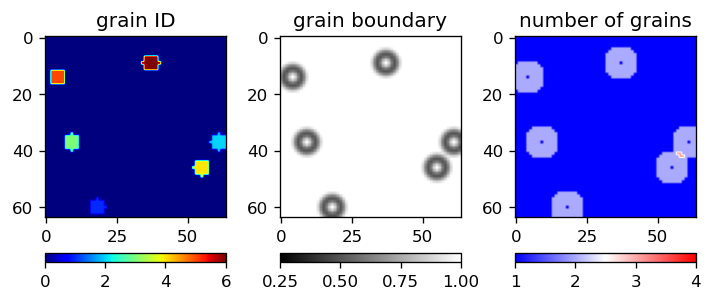

In [33]:
phi = np.zeros((number_of_grain,nx,ny))
phi_new = np.zeros((number_of_grain,nx,ny))
mf = np.zeros((15,nx,ny),dtype = int)
nf = np.zeros((nx,ny),dtype = int)

phi[0,:,:] = 1.0
nf[:,:] = 1
r_nuclei = 3.*dx # radius of the initial grains

for i in range(1,number_of_grain):
    x_nuclei = int(rand()*nx)
    y_nuclei = int(rand()*ny)
    for m in range(ny):
        for l in range(nx):
            if l > nx-1: 
                l = l - nx
            if l < 0:
                l = l + nx
            if m > ny-1:
                m = m - ny
            if m < 0:
                m = m + ny
            r = np.sqrt( (l *dx-x_nuclei*dx)**2 +(m*dy-y_nuclei*dy)**2 ) - r_nuclei
            tmp = np.sqrt(2.*www)/aaa*r
            phi_tmp = 0.5*(1.-np.sin(tmp))
            if tmp >= pi/2.:
                phi_tmp=0.
            if tmp <= -pi/2.:
                phi_tmp=1.
            if 0. < phi_tmp < 1.: 
                nf_tmp = nf[l,m]+1
                nf[l,m] = nf_tmp
                mf[nf_tmp-1,l,m] = i
                phi[i,l,m] = phi_tmp            
                phi[0,l,m] = phi[0,l,m]-phi[i,l,m]
                if phi[0,l,m] < 0.:
                    phi[0,l,m] = 0.
            if phi_tmp >= 1.: 
                nf_tmp = 1
                nf[l,m] = nf_tmp
                mf[0,l,m] = i
                phi[i,l,m] = phi_tmp            
                phi[0,l,m] = 0.

for m in range(0,ny):
    for l in range(0,nx):
        a = np.sum(phi[:,l,m])
        phi[:,l,m] = phi[:,l,m] / a
        gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])
        phi_max = 0.
        for n in range(nf[l,m]):
            i = mf[n,l,m]
            if phi[i,l,m] > phi_max:
                gi[l,m] = i
                phi_max = phi[i,l,m]

fig = plt.figure(figsize=(7,4))
fig.set_dpi(120)
plt.subplots_adjust(wspace=0.3)
        
plt.subplot(1,3, 1)
plt.imshow(gi, cmap='jet',
           vmin=0, vmax=number_of_grain-1)
plt.title('grain ID')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.subplot(1,3, 2)
plt.imshow(gb, cmap="gray",
           vmin=0.25, vmax=1.)
plt.title('grain boundary')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.subplot(1,3, 3)
plt.imshow(nf, cmap='bwr',
           vmin=1, vmax=4)
plt.title('number of grains')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.show()

### calculate time evolution of phase-field variables (simulate grain growth behavior) in 2D
In order to further simulate the grain growth, run this script for many times. Finally, the system will be a single crystal. 

nstep =  50


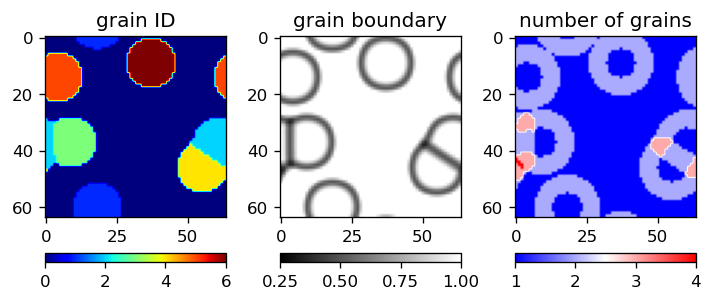

nstep =  100


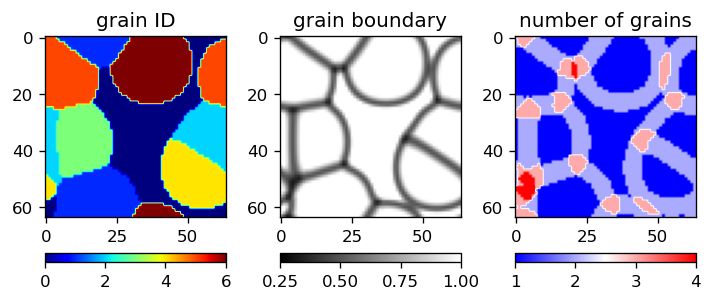

nstep =  150


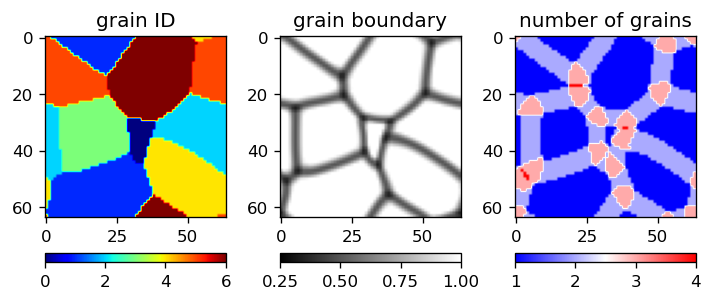

nstep =  200


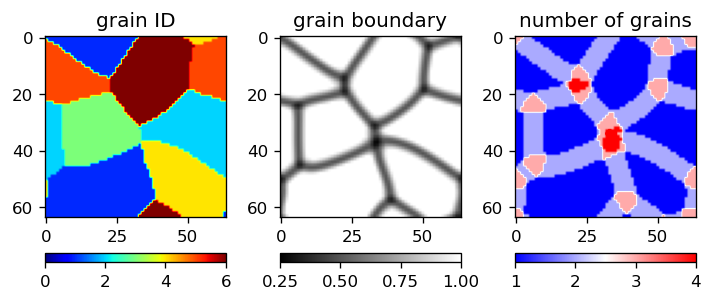

nstep =  250


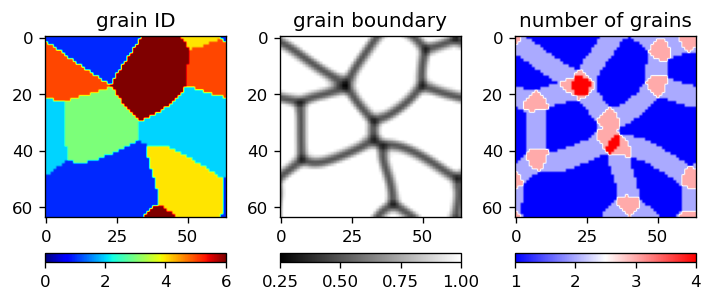

nstep =  300


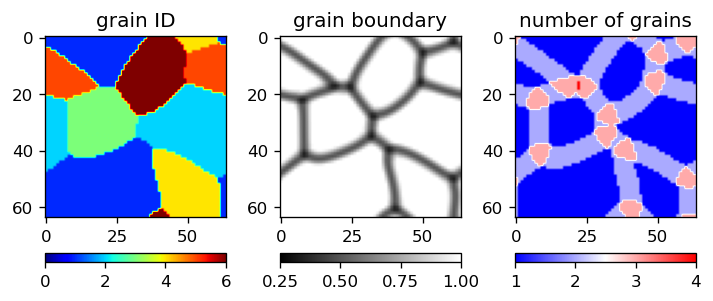

nstep =  350


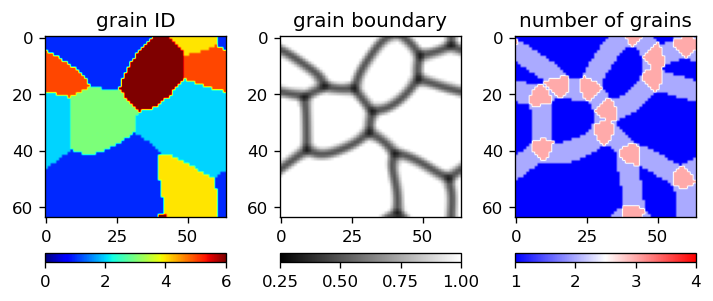

nstep =  400


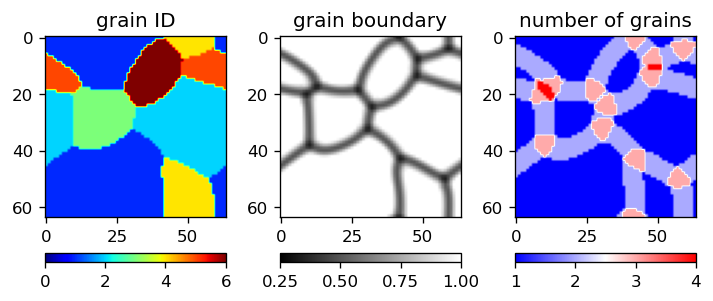

nstep =  450


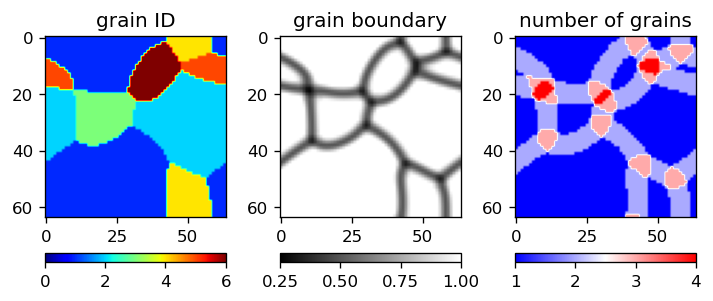

nstep =  500


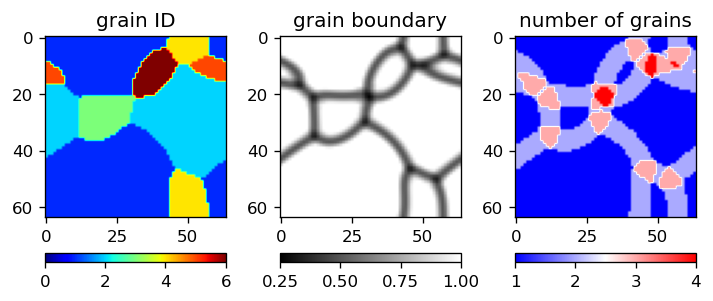

In [34]:
for nstep in range(1,nsteps+1):
    update_nfmf(phi,mf,nf)
    update_phasefield(phi,phi_new,mf,nf,eij)
    
    if nstep % 50 == 0:
        print('nstep = ', nstep)
        for m in range(0,ny):
            for l in range(0,nx):
                gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])
                phi_max = 0.
                for n in range(nf[l,m]):
                    i = mf[n,l,m]
                    if phi[i,l,m] > phi_max:
                        gi[l,m] = i
                        phi_max = phi[i,l,m]

        fig = plt.figure(figsize=(7,4))
        fig.set_dpi(120)
        plt.subplots_adjust(wspace=0.3)
        
        plt.subplot(1,3, 1)        
        plt.imshow(gi, cmap='jet',
                   vmin=0, vmax=number_of_grain-1)
        plt.title('grain ID')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
        plt.subplot(1,3, 2)        
        plt.imshow(gb, cmap='gray',
                   vmin=0.25, vmax=1.)
        plt.title('grain boundary')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
        plt.subplot(1,3, 3)        
        plt.imshow(nf, cmap='bwr',
                   vmin=1, vmax=4)
        plt.title('number of grains')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')      
        plt.show()    